# $x^2$ potential

In [1]:
import pickle
import numpy as np
import pycuda.gpuarray as gpuarray
from scipy.special import hyp1f1
import scipy.fftpack as fftpack
import pylab as plt
import time

#-------------------------------------------------------------------------------------
from pywignercuda_path import SetPyWignerCUDA_Path
SetPyWignerCUDA_Path()
from GPU_Wigner2D_GPitaevskii import *


In [2]:
%matplotlib inline

## Settings

In [3]:
class frame( GPU_Wigner2D_GPitaevskii_Bloch ):
    def __init__ (self,V_Source, V_Drain, gaussianSeparation):
        X_gridDIM = 2*512
        P_gridDIM =   512
        
        X_amplitude  = 32
        P_amplitude  = 18
        
        hBar = 1.
        dt    = 0.01
        
        timeSteps =        1000
        skipFrames =         50
        
        mass = 1.      
        
        #
        self.xScale = 2.16074     #  with this scale the x axis reads in micro meters
        
        self.energyScale = 0.5    #  with this scale the energy reads in KHz
        
        self.timeScale = 2        #  with this scale the time reads in mili seconds
        
        # Potential and derivative of potential in computational units
        X2_constant = 0.075            # Enveloping Harmonic oscillator
        gaussianSeparation = 0.75
        V_Drain =  3.
        V_Source = 2.
        k = 5. # 1/width of Gaussian potentials
        
        self.GPitaevskiiCoeff = 1.
        
        kinematicString  = '0.5*p*p/{mass}'.format(mass=mass)
        
        potentialString  = '(-0.1+{0}*pow(x,2) + {V_Source}*exp(-{k}*(x+{d})*(x+{d})))*Heaviside(-x-{d})'.format(
                        X2_constant, d=gaussianSeparation, V_Source=V_Source, k=k)
        
        potentialString += ' +( -0.1+4*(x+{d})+{V_Source} )*Heaviside(x+{d})   '.format(
                        d=gaussianSeparation, V_Source=V_Source, k=k)
        
                
        self.SetTimeTrack( dt, timeSteps, skipFrames,
        fileName='/home/rcabrera/DATA/Wigner2D_GPitaevskii/ATransistor_Ground_'+str(V_Source)+'.hdf5' )
        
        GPU_Wigner2D_GPitaevskii_Bloch.__init__(self,
            X_gridDIM,P_gridDIM,X_amplitude,P_amplitude,hBar,mass,potentialString,kinematicString)

    def Set_Initial_Condition(self):
        """
        """
        self.W_init = np.exp( -(self.X+1)**2/30. - self.P**2/30.  )
        
        norm =  np.sum(self.W_init)*self.dX*self.dP
        
        self.W_init /= norm

## Run

In [4]:
chemicalPotential = 50 #computational units

V_Source = 60 - chemicalPotential
V_Drain = 70 - chemicalPotential

gaussianSeparation = 1.


instance = frame( V_Source, V_Drain, gaussianSeparation)
print '							'
print ' 	Wigner2D propagator with damping	'
print '							'
print ' energy scale = ', instance.energyScale

instance.Set_Initial_Condition()

#instance.Set_Initial_Condition_HalfHarmonicOscillator()

#instance.Set_Initial_Condition_Boltzmann_HalfHarmonicOscillator()

							
 	Wigner2D propagator with damping	
							
 energy scale =  0.5


/usr/lib/pymodules/python2.7/matplotlib/font_manager.py:1236: UserWarning: findfont: Font family ['Times'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/lib/pymodules/python2.7/matplotlib/font_manager.py:1246: UserWarning: findfont: Could not match :family=Bitstream Vera Sans:style=normal:variant=normal:weight=normal:stretch=normal:size=24.0. Returning /usr/share/matplotlib/mpl-data/fonts/ttf/cmb10.ttf
  UserWarning)


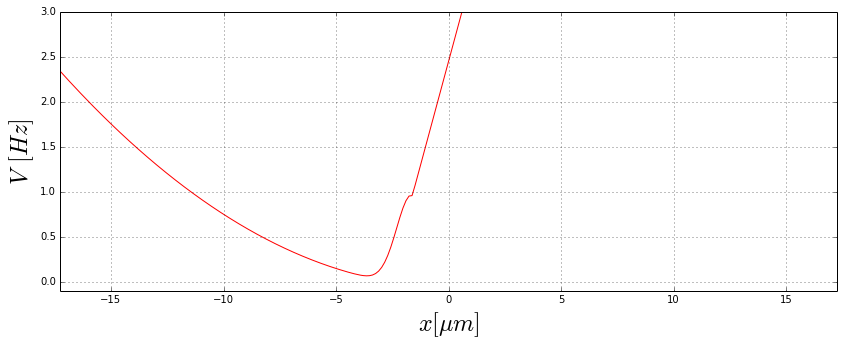

In [5]:
#print 'Potential'
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot( instance.X_range* instance.xScale , 
        instance.Potential(0,instance.X_range)* instance.energyScale ,'-' , color='r')


ax.set_xlim( -instance.X_amplitude*instance.xScale/4 , instance.X_amplitude*instance.xScale/4 )
ax.set_ylim(-0.1 , 3 )
ax.set_aspect(4)
axis_font = {'fontname':'Times', 'size':'24'}
ax.set_xlabel('$ x [\\mu m]$', **axis_font  )
ax.set_ylabel('$ V\, [Hz]$', **axis_font  )
ax.grid('on')

In [6]:
init_time = time.time()

W = instance.Run()

print 'computation time = ', (time.time() - init_time)/60. , 'min'

 X_gridDIM =  1024    P_gridDIM =  512
 dx =  0.0625  dp =  0.0703125
 dLambda =  0.0981747704247  dTheta =  0.174532925199
  
         GPU memory Total        5.24945068359 GB
         GPU memory Free         5.09395599365 GB
Initial W Norm =  (1+0j)
         GPU memory Free  post gpu loading  5.07051849365 GB
 ------------------------------------------------------------------------------- 
     Split Operator Propagator  GPU with damping                                 
 ------------------------------------------------------------------------------- 
        
        
step  0
step  50
step  100
step  150
step  200
step  250
step  300
step  350
step  400
step  450
step  500
step  550
step  600
step  650
step  700
step  750
step  800
step  850
step  900
step  950
step  1000
computation time =  0.316726016998 min


## Plots

min =  4.26696594697e-23  max =  0.0106103651966
normalization =  1.0


/usr/lib/pymodules/python2.7/matplotlib/collections.py:608: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != 'face':
/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


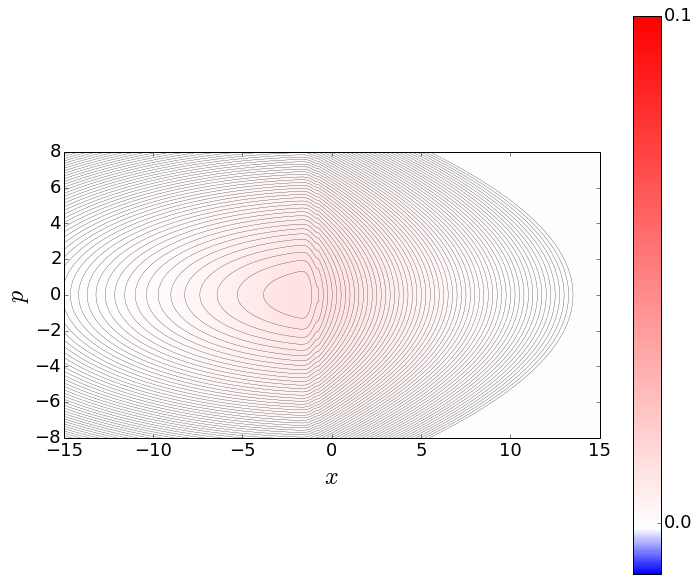

In [7]:
plot_init = instance.PlotWignerFrame( instance.W_init , ((-15.,15) ,(-8,8))  , (-0.01,0.1) , (0,60,1) )


min =  -0.00550340069036  max =  0.313344145839
normalization =  1.0


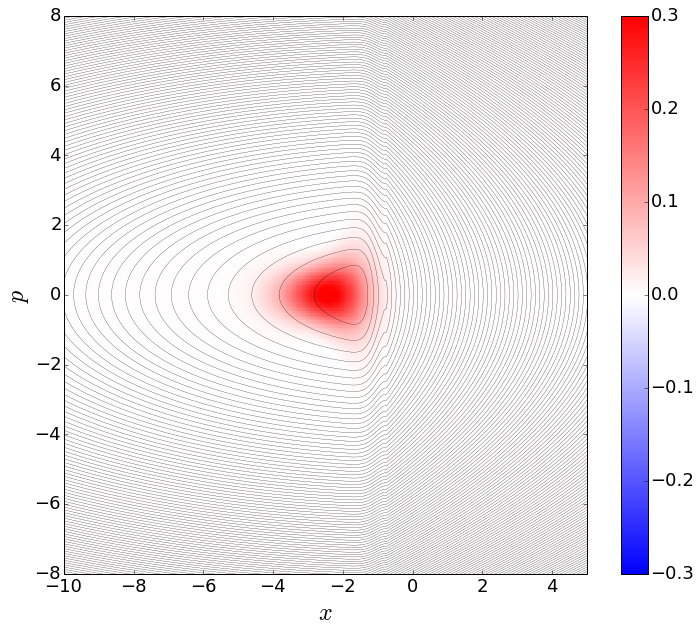

In [8]:
plot_end = instance.PlotWignerFrame( instance.W_0 , ((-10.,5) ,(-8,8))  , (-0.3,0.3) , (0,60,0.5))

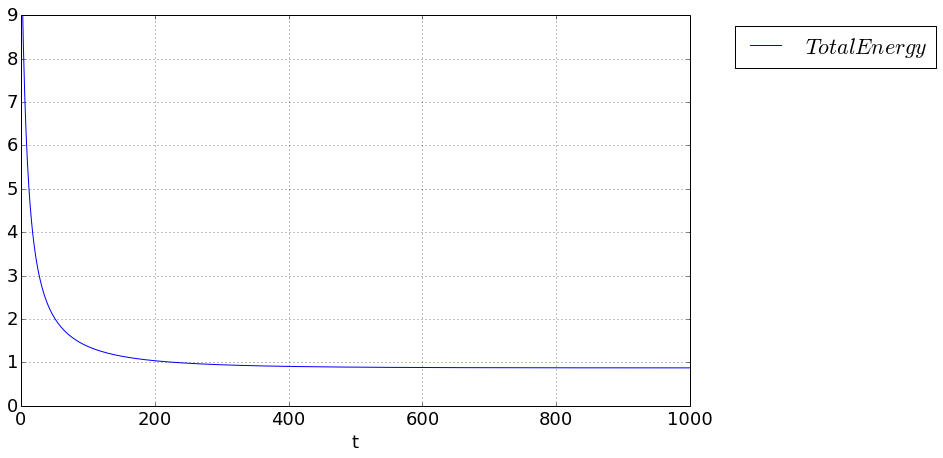

In [9]:
fig, ax = plt.subplots(figsize=(12, 7))

ax.plot( instance.TotalEnergyHistory  ,
        '-' , label = '$Total Energy$' , linewidth=1.)



ax.legend(bbox_to_anchor=(1.05, 1), loc=2, prop={'size':22})
ax.set_ylim( 0 , 9)
ax.set_xlabel('t')
ax.set_ylabel(' ')
ax.grid();

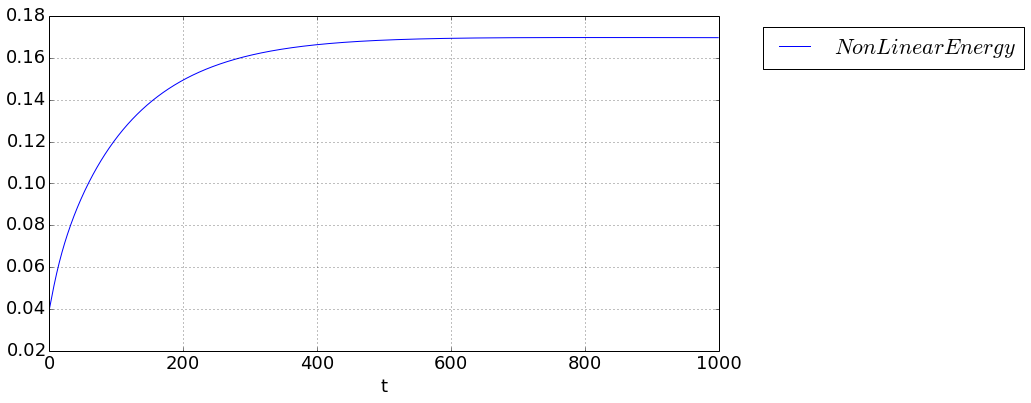

In [10]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(  instance.NonLinearEnergyHistory
        , '-' , label = '$Non Linear Energy$' , linewidth=1.)


ax.legend(bbox_to_anchor=(1.05, 1), loc=2, prop={'size':22})
#ax.set_ylim( 1.19 , 1.21 )
ax.set_xlabel('t')
ax.set_ylabel(' ')
ax.grid();

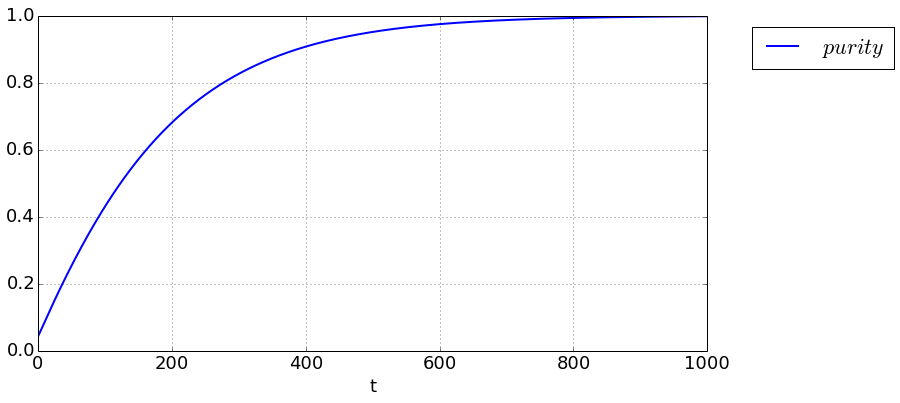

In [11]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(  instance.purity , '-' , label = '$purity $',linewidth=2.)


ax.legend(bbox_to_anchor=(1.05, 1), loc=2, prop={'size':22})
#ax.set_ylim( 0.99 , 1.01 )
ax.set_xlabel('t')
ax.set_ylabel(' ')
ax.grid();

## First Exited state

In [12]:
%time instance.Run_ExitedState1( )

         GPU memory Total        5.24945068359 GB
         GPU memory Free         5.08614349365 GB
Initial W Norm =  (1+0j)
         GPU memory Free  post gpu loading  5.05489349365 GB
 ------------------------------------------------------------------------------- 
     Split Operator Propagator  GPU with damping                                 
 ------------------------------------------------------------------------------- 
        
        
step  0
step  50
step  100
step  150
step  200
step  250
dt =  0.01
dt =  0.005
dt =  0.0025
dt =  0.00125
dt =  0.000625
dt =  0.0003125
dt =  0.00015625
dt =  7.8125e-05
dt =  3.90625e-05
dt =  1.953125e-05
dt =  9.765625e-06
dt =  4.8828125e-06
step  300
dt =  2.44140625e-06
dt =  1.220703125e-06
dt =  6.103515625e-07
dt =  3.0517578125e-07
dt =  1.52587890625e-07
dt =  7.62939453125e-08
dt =  3.81469726563e-08
dt =  1.90734863281e-08
dt =  9.53674316406e-09
dt =  4.76837158203e-09
dt =  2.38418579102e-09
dt =  1.19209289551e-09
dt =  5.9604

0

min =  -0.304102966884  max =  0.157037491253
normalization =  1.0


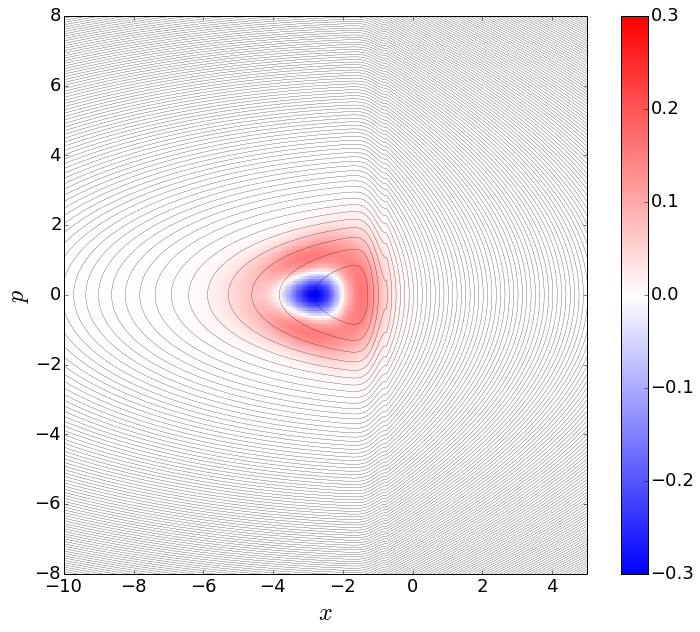

In [15]:
instance.PlotWignerFrame( instance.W_1 , ((-10.,5) ,(-8,8))  , (-0.3,0.3) , (0,60,0.5));